In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [54]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#PCA for feature reduction - Note: I tried it because it made the model fit faster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#semi-sup
from numpy import concatenate
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC


In [2]:
path = 'C:/dataset2/'

In [3]:
classes = ["Bar", "Casino", "Restaurant", "Library", "Hospital"]

def load_images(data_path, classes):
    data = []
    labels = []
    for class_n in classes:
        path = os.path.join(data_path, class_n)
        l = classes.index(class_n)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    print(img_path)
                    print("NOT RGB")
                    continue
                img = img.resize((256,256))
                img = np.array(img)
                data.append(img)
                labels.append(l)
            except Exception as e:
                print(f"Error : {e}")
    X = np.array(data) / 255.0
    y = np.array(labels)
    return X, y

X, y = load_images(path, classes)

C:/dataset2/Bar\bar_0527.jpg
NOT RGB
C:/dataset2/Restaurant\213596.jpg
NOT RGB
C:/dataset2/Restaurant\interieur_014_png.jpg
NOT RGB


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, stratify=y)

In [20]:
# Flattening
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_flat))
X_test_pca = pca.transform(scaler.transform(X_test_flat))

In [49]:
# parameter tuning + Pruning
best_accuracy = 0
best_params = {}
for max_depth in [3, 4, 5, 7, 10, None]:
    for min_samples_split in [2, 3, 5, 10, 20]:
        for ccp_alpha in [0.0, 0.1, 1.0]: # Added ccp_alpha for pruning
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha, random_state=42)
            dt.fit(X_train_pca, y_train)
            y_pred = dt.predict(X_test_pca)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha}

print(best_params)

dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train_pca, y_train)
y_pred = dt.predict(X_test_pca)

{'max_depth': 3, 'min_samples_split': 2, 'ccp_alpha': 0.0}


In [50]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.3848987108655617
Classification Report:
              precision    recall  f1-score   support

         Bar       0.52      0.36      0.43       102
      Casino       0.35      0.61      0.45       111
  Restaurant       0.32      0.34      0.33       109
     Library       0.28      0.17      0.21       102
    Hospital       0.49      0.42      0.45       119

    accuracy                           0.38       543
   macro avg       0.39      0.38      0.37       543
weighted avg       0.39      0.38      0.38       543



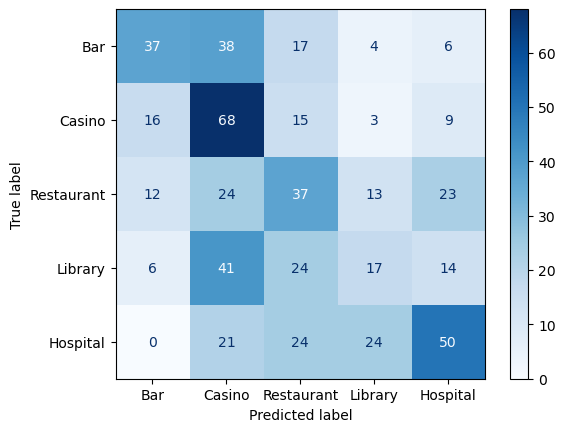

In [51]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()

In [55]:
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.80, random_state=1, stratify=y_train)

In [56]:
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

In [57]:
# Flattening
X_train_flat = X_train_mixed.reshape(X_train_mixed.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_flat))
X_test_pca = pca.transform(scaler.transform(X_test_flat))

In [62]:
best_accuracy = 0
best_params = {}
for max_depth in [3, 4 , 5 , 7 , 10, None]:
    for min_samples_split in [2, 3, 5, 10, 20]:
        for ccp_alpha in [0.0, 0.1, 1.0]: # Added ccp_alpha for pruning
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha, random_state=42)
            dt.fit(X_train_pca, y_train)
            y_pred = dt.predict(X_test_pca)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': None, 'min_samples_split': min_samples_split, 'ccp_alpha': 0.0}

print(best_params)

dt = DecisionTreeClassifier(**best_params)
# dt.fit(X_train_pca, y_train)
# y_pred = dt.predict(X_test_pca)

self_training_model = SelfTrainingClassifier(dt, criterion='k_best')
self_training_model.fit(X_train_pca, y_train_mixed)
y_pred = self_training_model.predict(X_test_pca)

{'max_depth': None, 'min_samples_split': 2, 'ccp_alpha': 0.0}


In [63]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.30939226519337015
Classification Report:
              precision    recall  f1-score   support

         Bar       0.25      0.26      0.26       102
      Casino       0.44      0.40      0.42       111
  Restaurant       0.20      0.20      0.20       109
     Library       0.26      0.29      0.27       102
    Hospital       0.43      0.38      0.40       119

    accuracy                           0.31       543
   macro avg       0.31      0.31      0.31       543
weighted avg       0.32      0.31      0.31       543



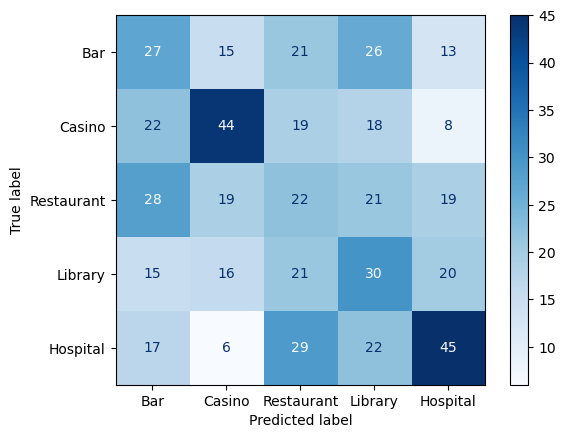

In [64]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()